In [1]:
import numpy as np
from pathlib import Path
import csv, re, os
import matplotlib.pyplot as plt
import pandas as pd
# Pre-Processing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
# Keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.utils.np_utils import to_categorical 
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN, History
from keras import regularizers
import keras.backend as K

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def Load_Data():
    # Get Input and Target Data
    input_data = np.ones([1, 57])
    target_data_binary_PHQ = [0]
    target_data_score_PHQ = [0]
    
    i = 1
    target_data_csv = Path('D:/DAIC WOZ # EMNA - do not use/full_dataset.csv')
    with open(target_data_csv, 'r') as csvFile:
        reader = csv.reader(csvFile)
        for row in reader:
            try:
                participant_ID = str(re.split('\t', row[0])[0])
                binary_PHQ8 = int(re.split('\t', row[1])[0])
                score_PHQ8 = int(re.split('\t', row[2])[0])
                print(" ## \n Participant ID is:{}, with Binary PHQ:{} , and Score PHQ:{} : ", participant_ID, binary_PHQ8, score_PHQ8)
                
                csv_file_path ='D:/all_data/'+participant_ID+'_P/split/Participant/'
                if os.path.exists(csv_file_path):
                    input_directory = Path(csv_file_path)
                    for my_csv_filename in input_directory.glob("*_AUDIO_*.csv"):  
                        # Extract the .csv filename   
                        my_csv_filename = my_csv_filename.stem
                        print("## \n Retrieving coef matrix from file: ", my_csv_filename)

                        io = pd.read_csv(csv_file_path+my_csv_filename+'.csv', sep=",", usecols=(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,60))

                        # Get the Matrix
                        i = i+1
                        io = np.array(io, dtype=np.float32)
                        print("###################################################")
                        
                        input_data = np.append(input_data, io, axis=0)                       
                        for j in range(io.shape[0]):
                            target_data_binary_PHQ.append(binary_PHQ8)
                            target_data_score_PHQ.append(score_PHQ8)
                            
            except ValueError:
                print("Skipping the following line: ", row[0])
    csvFile.close()            
                
    print("the size of my list-input-matrix: ", i)
    
    input_data_final = np.delete(input_data, 0, 0)
    target_data_binary_PHQ_final = np.delete(target_data_binary_PHQ, 0, 0)
    target_data_score_PHQ_final = np.delete(target_data_score_PHQ, 0, 0)
    
    return input_data_final, target_data_binary_PHQ_final, target_data_score_PHQ_final

# Loading data
input_data, target_data_binary_PHQ, target_data_score_PHQ = Load_Data()




Using TensorFlow backend.


Skipping the following line:  Participant_ID
 ## 
 Participant ID is:{}, with Binary PHQ:{} , and Score PHQ:{} :  303 0 0
## 
 Retrieving coef matrix from file:  0303_AUDIO_0
###################################################
## 
 Retrieving coef matrix from file:  0303_AUDIO_1
###################################################
## 
 Retrieving coef matrix from file:  0303_AUDIO_10
###################################################
## 
 Retrieving coef matrix from file:  0303_AUDIO_100
###################################################
## 
 Retrieving coef matrix from file:  0303_AUDIO_101
###################################################
## 
 Retrieving coef matrix from file:  0303_AUDIO_102
###################################################
## 
 Retrieving coef matrix from file:  0303_AUDIO_11
###################################################
## 
 Retrieving coef matrix from file:  0303_AUDIO_12
###################################################
## 
 Retrieving coef matrix f

In [2]:
input_data.shape

(2490455, 57)

In [3]:
data=pd.DataFrame(input_data)
data.describe()

0             1             2             3             4   \
count  2.490455e+06  2.490455e+06  2.490455e+06  2.490455e+06  2.490455e+06   
mean  -2.886610e+00 -7.848475e-01 -5.086559e-01 -6.990194e-01 -6.791107e-01   
std    3.566562e+00  1.525395e+00  1.275818e+00  9.459156e-01  8.808987e-01   
min   -1.419003e+01 -9.499455e+00 -6.935476e+00 -6.881899e+00 -5.385520e+00   
25%   -6.373486e+00 -1.552965e+00 -1.349124e+00 -1.172407e+00 -1.162533e+00   
50%   -1.837391e+00 -6.083647e-01 -6.058561e-01 -5.583820e-01 -5.860266e-01   
75%   -1.953993e-14  2.217162e-02  1.049838e-01 -1.082735e-02 -2.536103e-03   
max    9.122910e+00  6.566734e+00  6.519344e+00  3.439885e+00  3.935709e+00   

                 5             6             7             8             9   \
count  2.490455e+06  2.490455e+06  2.490455e+06  2.490455e+06  2.490455e+06   
mean  -6.286788e-01 -3.301165e-01 -2.632128e-01 -1.545345e-01 -2.423118e-01   
std    7.585952e-01  6.355945e-01  5.794383e-01  5.548135e-01  4.773912e-01   
min   -4.911435e+00 -4.391728e+00 -3.928926e+00 -3.385232e+00 -3.165742e+00   
25%   -1.069435e+00 -6.921793e-01 -5.781703e-01 -4.733514e-01 -5.061029e-01   
50%   -5.298897e-01 -2.750965e-01 -2.016632e-01 -1.186031e-01 -1.876148e-01   
75%   -7.596465e-02  1.104984e-02  3.803199e-02  1.332558e-01  1.127501e-02   
max    3.560371e+00  3.570163e+00  3.043211e+00  3.108714e+00  2.750388e+00   

       ...            47            48            49            50  \
count  ...  2.490455e+06  2.490455e+06  2.490455e+06  2.490455e+06   
mean   ...  1.521679e-02  1.582929e-02  3.971306e-02  3.632109e-02   
std    ...  6.432378e+00  6.158109e+00  5.616514e+00  5.225653e+00   
min    ... -4.464558e+01 -4.510346e+01 -4.490970e+01 -4.112171e+01   
25%    ... -3.585063e+00 -3.439475e+00 -3.148546e+00 -2.943728e+00   
50%    ...  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    ...  3.599118e+00  3.429488e+00  3.136520e+00  2.950906e+00   
max    ...  4.574831e+01  3.986323e+01  4.591668e+01  5.063490e+01   

                 51            52            53            54            55  \
count  2.490455e+06  2.490455e+06  2.490455e+06  2.490455e+06  2.490455e+06   
mean   3.726536e-02  3.087951e-02  2.457090e-02  2.264444e-02  2.860866e-02   
std    5.044393e+00  4.563021e+00  4.219952e+00  4.067691e+00  3.906817e+00   
min   -3.956762e+01 -4.084458e+01 -3.889404e+01 -3.480339e+01 -3.362213e+01   
25%   -2.814420e+00 -2.578505e+00 -2.384417e+00 -2.272221e+00 -2.158093e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    2.853341e+00  2.618690e+00  2.418247e+00  2.315931e+00  2.200534e+00   
max    3.946264e+01  4.468849e+01  3.999957e+01  4.370761e+01  4.606602e+01   

                 56  
count  2.490455e+06  
mean   1.546863e+01  
std    5.831343e+01  
min   -1.765771e+02  
25%    4.460729e+00  
50%    3.782855e+01  
75%    4.302207e+01  
max    6.853945e+01  

[8 rows x 57 columns]

In [4]:
# Splitting into Training and Testing datasets
input_data = np.asarray(input_data, dtype=np.float32)
target_bin = np.asarray(target_data_binary_PHQ, dtype=int)
target_score = np.asarray(target_data_score_PHQ, dtype=np.int64)

#"Testing Binary Score"
x_train, x_validation, y_train, y_validation = train_test_split(input_data, target_bin, test_size = 0.2 , random_state = 42)

#"Testing PHQ scores"
#x_train, x_validation, y_train, y_validation = train_test_split(input_data, target_score, test_size = 0.2 , random_state = 42)

x_validation, x_test, y_validation, y_test = train_test_split(x_validation, y_validation, test_size = 0.4 , random_state = 42)

print("###split complete###")

scaler = preprocessing.StandardScaler()
x_train = scaler.fit_transform(x_train)
x_validation = scaler.transform(x_validation)
x_test = scaler.transform(x_test)
print("Done Scaling!")


###split complete###
Done Scaling!


In [5]:
data=pd.DataFrame(x_train)
data.describe()

0             1             2             3             4   \
count  1.992364e+06  1.992364e+06  1.992364e+06  1.992364e+06  1.992364e+06   
mean  -7.888394e-10 -3.208968e-09 -1.085803e-08  1.041574e-09  1.072209e-10   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -3.168948e+00 -5.716724e+00 -5.036479e+00 -6.276342e+00 -5.341052e+00   
25%   -9.778943e-01 -5.031660e-01 -6.587721e-01 -5.002097e-01 -5.485092e-01   
50%    2.944715e-01  1.156786e-01 -7.613626e-02  1.485178e-01  1.058297e-01   
75%    8.095387e-01  5.289783e-01  4.806237e-01  7.273359e-01  7.681031e-01   
max    3.367346e+00  4.821769e+00  5.487990e+00  4.374620e+00  4.818467e+00   

                 5             6             7             8             9   \
count  1.992364e+06  1.992364e+06  1.992364e+06  1.992364e+06  1.992364e+06   
mean   9.339466e-09  1.577679e-09  2.438797e-09  2.277008e-09 -2.787743e-09   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -5.646632e+00 -6.391672e+00 -6.324088e+00 -5.822006e+00 -6.124575e+00   
25%   -5.806316e-01 -5.699095e-01 -5.436592e-01 -5.751378e-01 -5.522032e-01   
50%    1.302196e-01  8.635463e-02  1.063492e-01  6.496721e-02  1.147695e-01   
75%    7.278585e-01  5.371208e-01  5.201354e-01  5.190209e-01  5.312725e-01   
max    5.523996e+00  6.137709e+00  5.705707e+00  5.881002e+00  6.270695e+00   

       ...            47            48            49            50  \
count  ...  1.992364e+06  1.992364e+06  1.992364e+06  1.992364e+06   
mean   ... -6.280081e-09 -9.839431e-09 -2.050599e-09 -3.769963e-09   
std    ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    ... -6.820598e+00 -6.195234e+00 -8.002029e+00 -7.803877e+00   
25%    ... -5.599092e-01 -5.612907e-01 -5.678526e-01 -5.704130e-01   
50%    ... -3.032529e-03 -2.125230e-03 -6.720750e-03 -6.832288e-03   
75%    ...  5.570727e-01  5.542886e-01  5.517043e-01  5.576116e-01   
max    ...  6.723864e+00  6.470382e+00  8.167861e+00  9.679641e+00   

                 51            52            53            54            55  \
count  1.992364e+06  1.992364e+06  1.992364e+06  1.992364e+06  1.992364e+06   
mean  -6.996163e-09  1.830414e-09 -8.933798e-09  1.066465e-08  5.375405e-09   
std    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min   -7.850301e+00 -8.954715e+00 -8.651184e+00 -8.560298e+00 -8.607490e+00   
25%   -5.653021e-01 -5.715564e-01 -5.712206e-01 -5.640174e-01 -5.593386e-01   
50%   -6.593184e-03 -7.020620e-03 -5.506840e-03 -5.827891e-03 -7.087897e-03   
75%    5.584493e-01  5.669801e-01  5.671177e-01  5.639123e-01  5.558260e-01   
max    7.816304e+00  9.782747e+00  9.472598e+00  1.073725e+01  9.733795e+00   

                 56  
count  1.992364e+06  
mean   2.513947e-09  
std    1.000000e+00  
min   -3.294225e+00  
25%   -1.889683e-01  
50%    3.834043e-01  
75%    4.724783e-01  
max    9.100962e-01  

[8 rows x 57 columns]

In [6]:
# Dimensions Update
x_train = np.expand_dims(x_train, -1)
x_validation = np.expand_dims(x_validation, -1)
x_test = np.expand_dims(x_test, -1)
print("Done!")

Done!


In [8]:
from keras.models import load_model, Model

reg = regularizers.l1_l2(l1=0.001, l2=0.00)

checkpoints_path = "C:/Users/yobitrust/Desktop/output_TF/weights.{epoch:02d}-{val_loss:.2f}.hdf5"           

base_model = load_model('D:/RAVDESS/RAVDESS_model.h5')

# Freeze the layers which you don't want to train. Here I am freezing the first 2 layers.
for layer in base_model.layers[:2]:
    layer.trainable = False
    
#Adding custom Layers 
x = base_model.layers[-3].output
#x = Flatten()(x)
x = Dense(30, activation="tanh")(x)
x = Dropout(0.002)(x)
x = Dense(20, activation="tanh")(x)
x = Dense(10, activation="tanh")(x)

predictions = Dense(1, activation="sigmoid")(x)

# creating the final model 
model_final = Model(input = base_model.input, output = predictions)


# Compiler
#opt = SGD(lr=0.0001, decay=1e-6, momentum=0.9)
opt = Adam(lr=1e-3, decay=1e-6)
model_final.compile(optimizer = opt, loss = root_mean_squared_error, metrics=['accuracy'])  

model_final.summary()

#checkpoint of the model (based on val_loss)
checkpoint = ModelCheckpoint(checkpoints_path, verbose=1, save_weights_only=True, save_best_only=True)

#early stopping
earlyStopping = EarlyStopping(patience = 10, verbose=1)

#learning rate reduction
reducelr = ReduceLROnPlateau(verbose = 1, patience= 4)

#terminating on NaN loss values
nanStopping = TerminateOnNaN()

#saving callback history
savingHistory = History()

#callbacks
callbacks_list = [checkpoint, earlyStopping,reducelr, nanStopping, savingHistory]

history = model_final.fit(x_train, y_train, epochs = 300, batch_size = 170, validation_data=(x_validation, y_validation), verbose=1, shuffle=True, callbacks=callbacks_list)


C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:24: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ls..., outputs=Tensor("de...)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1_input (InputLayer)    (None, 57, 1)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 57, 50)            10400     
_________________________________________________________________
batch_normalization_1 (Batch (None, 57, 50)            200       
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                14560     
_________________________________________________________________
batch_normalization_2 (Batch (None, 40)                160       
_________________________________________________________________
dense_1 (Dense)              (None, 30)                1230      
_________________________________________________________________
dense_5 (Dense)              (None, 30)                930       
__________

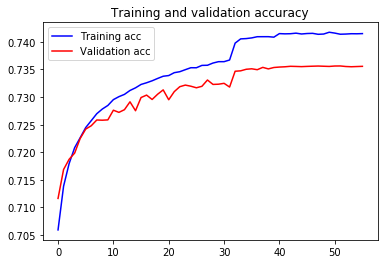

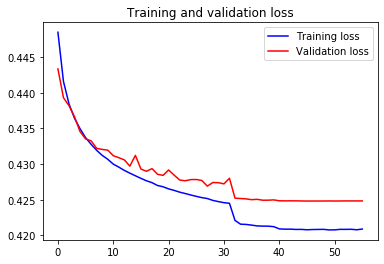

In [10]:
# Network Performances Display
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [17]:
from sklearn.metrics import classification_report

y_pred = model_final.predict(x_test, batch_size=32)


In [ ]:
# make predictions
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

print("done")

In [12]:
model_final.save('D:/RAVDESS/generalization_model.h5')

In [13]:
input_data.shape

(2490455, 57)

In [18]:
y_pred1 = np.around(y_pred)

In [19]:
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.74      0.95      0.83    138645
           1       0.69      0.23      0.34     60592

    accuracy                           0.73    199237
   macro avg       0.71      0.59      0.59    199237
weighted avg       0.72      0.73      0.68    199237



In [20]:
data=pd.DataFrame(y_pred1)
data.describe()

0
count  199237.000000
mean        0.101010
std         0.301343
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C8590347F0>]],
      dtype=object)

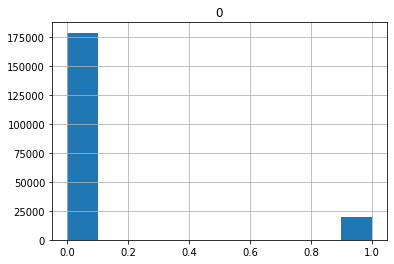

In [21]:
data.hist()

C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:158: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:159: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:161: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.set_visible instead.
C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:162: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.set_visible instead.
C:\Users\yobitrust\Anaconda3\envs\tf_gpu\lib

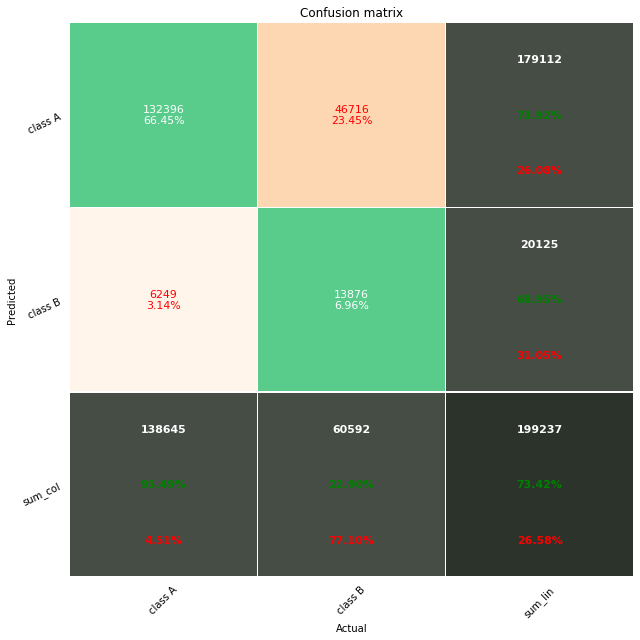

In [26]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.collections import QuadMesh
import seaborn as sn

from sklearn.metrics import confusion_matrix


columns=None
annot=True
fmt='.2f'
lw=0.5
cbar=False
pred_val_axis='lin'
    
def get_new_fig(fn, figsize=[9,9]):
    """ Init graphics """
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()   #Get Current Axis
    ax1.cla() # clear existing plot
    return fig1, ax1

def configcell_text_and_colors(array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0):
    """
      config cell text and colors
      and return text elements to add and to dell
      @TODO: use fmt
    """
    text_add = []; text_del = [];
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:,col]
    ccl = len(curr_column)

    #last line  and/or last column
    if(col == (ccl - 1)) or (lin == (ccl - 1)):
        #tots and percents
        if(cell_val != 0):
            if(col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(col == ccl - 1):
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif(lin == ccl - 1):
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ['%.2f%%'%(per_ok), '100%'] [per_ok == 100]

        #text to DEL
        text_del.append(oText)

        #text to ADD
        font_prop = fm.FontProperties(weight='bold', size=fz)
        text_kwargs = dict(color='w', ha="center", va="center", gid='sum', fontproperties=font_prop)
        lis_txt = ['%d'%(cell_val), per_ok_s, '%.2f%%'%(per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy(); dic['color'] = 'g'; lis_kwa.append(dic);
        dic = text_kwargs.copy(); dic['color'] = 'r'; lis_kwa.append(dic);
        lis_pos = [(oText._x, oText._y-0.3), (oText._x, oText._y), (oText._x, oText._y+0.3)]
        for i in range(len(lis_txt)):
            newText = dict(x=lis_pos[i][0], y=lis_pos[i][1], text=lis_txt[i], kw=lis_kwa[i])
            #print 'lin: %s, col: %s, newText: %s' %(lin, col, newText)
            text_add.append(newText)
        #print '\n'

        #set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if(col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if(per > 0):
            txt = '%s\n%.2f%%' %(cell_val, per)
        else:
            if(show_null_values == 0):
                txt = ''
            elif(show_null_values == 1):
                txt = '0'
            else:
                txt = '0\n0.0%'
        oText.set_text(txt)

        #main diagonal
        if(col == lin):
            #set color of the textin the diagonal to white
            oText.set_color('w')
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color('r')

    return text_add, text_del

def insert_totals(df_cm):
    """ insert total column and line (the last ones) """
    sum_col = []
    for c in df_cm.columns:
        sum_col.append( df_cm[c].sum() )
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append( item_line[1].sum() )
    df_cm['sum_lin'] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc['sum_col'] = sum_col
    




def pretty_plot_confusion_matrix(df_cm, annot=True, cmap="Oranges", fmt='.2f', fz=11,
      lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='y'):
    """
      print conf matrix with default layout (like matlab)
      params:
        df_cm          dataframe (pandas) without totals
        annot          print text in each cell
        cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
        fz             fontsize
        lw             linewidth
        pred_val_axis  where to show the prediction values (x or y axis)
                        'col' or 'x': show predicted values in columns (x axis) instead lines
                        'lin' or 'y': show predicted values in lines   (y axis)
    """
    if(pred_val_axis in ('col', 'x')):
        xlbl = 'Predicted'
        ylbl = 'Actual'
    else:
        xlbl = 'Actual'
        ylbl = 'Predicted'
        df_cm = df_cm.T


    # create "Total" column
    insert_totals(df_cm)

    #this is for print allways in the same window
    fig, ax1 = get_new_fig('Conf matrix default', figsize)

    #thanks for seaborn
    ax = sn.heatmap(df_cm, annot=annot, annot_kws={"size": fz}, linewidths=lw, ax=ax1,
                    cbar=cbar, cmap=cmap, linecolor='w', fmt=fmt)

    #set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, fontsize = 10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation = 25, fontsize = 10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    #face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    #iter in text elements
    array_df = np.array( df_cm.to_records(index=False).tolist() )
    text_add = []; text_del = [];
    posi = -1 #from left to right, bottom to top.
    for t in ax.collections[0].axes.texts: #ax.texts:
        pos = np.array( t.get_position()) - [0.5,0.5]
        lin = int(pos[1]); col = int(pos[0]);
        posi += 1
        #print ('>>> pos: %s, posi: %s, val: %s, txt: %s' %(pos, posi, array_df[lin][col], t.get_text()))

        #set text
        txt_res = configcell_text_and_colors(array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values)

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    #remove the old ones
    for item in text_del:
        item.remove()
    #append the new ones
    for item in text_add:
        ax.text(item['x'], item['y'], item['text'], **item['kw'])

    #titles and legends
    ax.set_title('Confusion matrix')
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  #set layout slim
    plt.show() 
    
    
    
#data
if(not columns):
    #labels axis integer:
    ##columns = range(1, len(np.unique(y_test))+1)
    #labels axis string:
    from string import ascii_uppercase
    columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

confm = confusion_matrix(y_test, y_pred1)
cmap = 'Oranges';
fz = 11;
figsize=[9,9];
show_null_values = 2
df_cm = pd.DataFrame(confm, index=columns, columns=columns)
pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)
